In [6]:
import pandas as pd
import numpy as np
import os.path as osp
import torch 

from changeit3d.in_out.basics import splitall, pickle_data, unpickle_data
from changeit3d.utils.feature_extraction import extract_visual_features

In [17]:
top_img_dir = '../../data/shapetalk/images/full_size'
all_model_uids = '../../data/shapetalk/language/misc/all_model_uids_used.csv'
top_out_dir = '../../data/pretrained/shape_latents'

method = 'resnet101' # or 'resnet34'


img_size = 224
img_ending = '.png'

gpu_id = '3'
device = torch.device("cuda:" + gpu_id)

In [3]:
df = pd.read_csv(all_model_uids)
print(len(df))
df.head(1)

36391


,model_uid
0,airplane/ModelNet/airplane_0001


In [4]:
img_files = top_img_dir + '/' + df.model_uid + img_ending
df = df.assign(img_files=img_files)
assert all(df.img_files.apply(osp.exists)), 'all files exist'

In [5]:
# Extract features
feats = extract_visual_features(img_files.tolist(), img_size, method=method, device=device)
assert len(df) == len(feats)

In [13]:
# Pass them to a dictionary
shape_to_latent = dict()
cnt = 0
for filename, feat in zip(img_files, feats):
    
    shape_uid = osp.join(*splitall(filename)[-3:])[:-len(img_ending)]
    shape_to_latent[shape_uid] = feat
    assert df.model_uid.iloc[cnt] == shape_uid
    cnt += 1
assert len(shape_to_latent) == len(df)

In [14]:
pickle_data(osp.join(top_out_dir, f'{method}_latent_codes.pkl'), shape_to_latent)

In [21]:
## OPTIONAL: 
    # Push features back to GPU to do nearest-neighbors

from changeit3d.utils.distances import k_euclidean_neighbors    
from PIL import Image
shape_to_latent = next(unpickle_data(osp.join(top_out_dir, f'{method}_latent_codes.pkl')))

feats = []
for filename in img_files:
    shape_uid = osp.join(*splitall(filename)[-3:])[:-len(img_ending)]    
    feats.append(shape_to_latent[shape_uid])
feats = np.array(feats)

In [18]:
feats = torch.from_numpy(feats).to(device)
print(feats.shape)

torch.Size([36391, 2048])


In [19]:
# Find Neighbors.
n_imgs = len(feats)
identities = torch.arange(n_imgs)

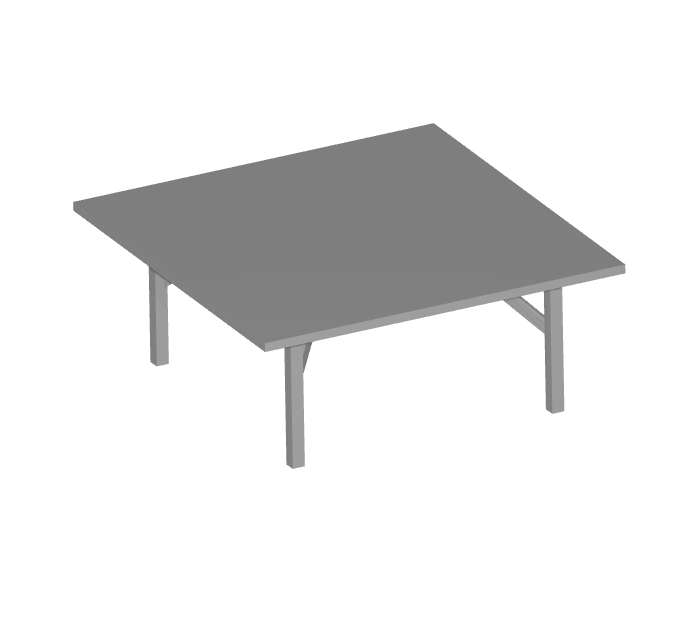

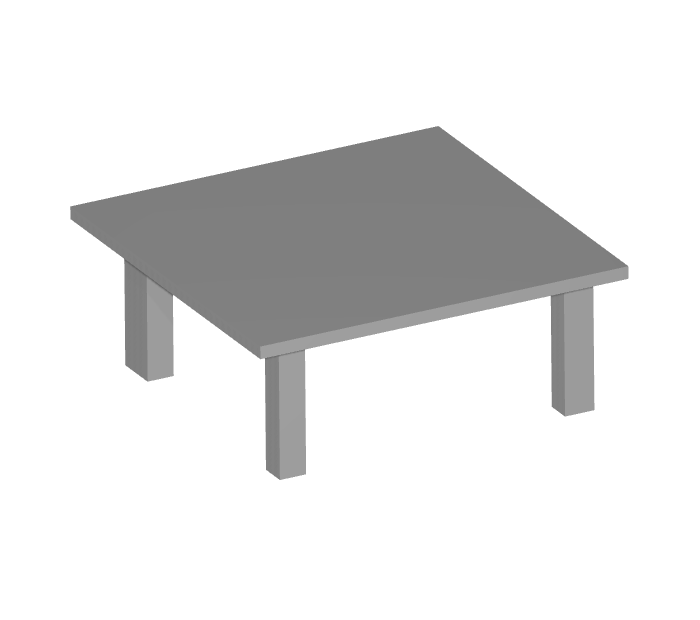

In [25]:
max_k = 2
r_id = np.random.choice(n_imgs-1, 1)[0]
n_dists, n_ids = k_euclidean_neighbors(max_k, feats[r_id:r_id+1], feats, exclude_identity=False, identities=identities)
n_dists = n_dists.cpu().numpy()
n_ids = n_ids.cpu().numpy()

for im_file in df.img_files.iloc[n_ids[0]]:
    display(Image.open(im_file))